# Importing Libraries

In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
import pandas as pd
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import arma_order_select_ic
from itertools import product
from statsmodels.tsa.arima.model import ARIMA

import pandas as pd
import statsmodels.api as sm
import matplotlib
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import seaborn as sns
from pandas import Series
from matplotlib import pyplot

In [2]:
df = pd.read_excel("superstore.xls")

# Basic EDA

In [3]:
df['Category'].value_counts()


Category
Office Supplies    6026
Furniture          2121
Technology         1847
Name: count, dtype: int64

In [4]:
df.info


<bound method DataFrame.info of       Row ID        Order ID Order Date  Ship Date       Ship Mode  \
0          1  CA-2016-152156 2016-11-08 2016-11-11    Second Class   
1          2  CA-2016-152156 2016-11-08 2016-11-11    Second Class   
2          3  CA-2016-138688 2016-06-12 2016-06-16    Second Class   
3          4  US-2015-108966 2015-10-11 2015-10-18  Standard Class   
4          5  US-2015-108966 2015-10-11 2015-10-18  Standard Class   
...      ...             ...        ...        ...             ...   
9989    9990  CA-2014-110422 2014-01-21 2014-01-23    Second Class   
9990    9991  CA-2017-121258 2017-02-26 2017-03-03  Standard Class   
9991    9992  CA-2017-121258 2017-02-26 2017-03-03  Standard Class   
9992    9993  CA-2017-121258 2017-02-26 2017-03-03  Standard Class   
9993    9994  CA-2017-119914 2017-05-04 2017-05-09    Second Class   

     Customer ID     Customer Name    Segment        Country             City  \
0       CG-12520       Claire Gute   Consumer 

In [5]:
df.describe()


,Row ID,Order Date,Ship Date,Postal Code,Sales,Quantity,Discount,Profit
count,9994.000000,9994,9994,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000
mean,4997.500000,2016-04-30 00:07:12.259355648,2016-05-03 23:06:58.571142912,55190.379428,229.858001,3.789574,0.156203,28.656896
min,1.000000,2014-01-03 00:00:00,2014-01-07 00:00:00,1040.000000,0.444000,1.000000,0.000000,-6599.978000
25%,2499.250000,2015-05-23 00:00:00,2015-05-27 00:00:00,23223.000000,17.280000,2.000000,0.000000,1.728750
50%,4997.500000,2016-06-26 00:00:00,2016-06-29 00:00:00,56430.500000,54.490000,3.000000,0.200000,8.666500
75%,7495.750000,2017-05-14 00:00:00,2017-05-18 00:00:00,90008.000000,209.940000,5.000000,0.200000,29.364000
max,9994.000000,2017-12-30 00:00:00,2018-01-05 00:00:00,99301.000000,22638.480000,14.000000,0.800000,8399.976000
std,2885.163629,NaN,NaN,32063.693350,623.245101,2.225110,0.206452,234.260108


In [6]:
df['Sub-Category'].value_counts()


Sub-Category
Binders        1523
Paper          1370
Furnishings     957
Phones          889
Storage         846
Art             796
Accessories     775
Chairs          617
Appliances      466
Labels          364
Tables          319
Envelopes       254
Bookcases       228
Fasteners       217
Supplies        190
Machines        115
Copiers          68
Name: count, dtype: int64

In [7]:
df.isnull().sum()


Row ID           0
Order ID         0
Order Date       0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Category         0
Sub-Category     0
Product Name     0
Sales            0
Quantity         0
Discount         0
Profit           0
dtype: int64

We are going to do time series analysis and forecasting for furniture sales.

In [8]:
furniture = df.loc[df['Category'] == 'Furniture']

We have a good 4-year furniture sales data. 

In [9]:
furniture['Order Date'].min()

Timestamp('2014-01-06 00:00:00')

In [10]:
furniture['Order Date'].max()

Timestamp('2017-12-30 00:00:00')

# Data preprocessing

This step includes removing columns we do not need, check missing values, aggregate sales by date and so on.

In [11]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
furniture.drop(cols, axis=1, inplace=True)
furniture = furniture.sort_values('Order Date')

In [12]:
furniture.head()

,Order Date,Sales
7474,2014-01-06,2573.820
7660,2014-01-07,76.728
866,2014-01-10,51.940
716,2014-01-11,9.940
2978,2014-01-13,545.940


In [13]:
furniture.isnull().sum()

Order Date    0
Sales         0
dtype: int64

In [14]:
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()

In [15]:
furniture.head()

,Order Date,Sales
0,2014-01-06,2573.820
1,2014-01-07,76.728
2,2014-01-10,51.940
3,2014-01-11,9.940
4,2014-01-13,879.939


# Indexing with time series data

In [16]:
furniture = furniture.set_index('Order Date')
furniture.index

DatetimeIndex(['2014-01-06', '2014-01-07', '2014-01-10', '2014-01-11',
               '2014-01-13', '2014-01-14', '2014-01-16', '2014-01-19',
               '2014-01-20', '2014-01-21',
               ...
               '2017-12-18', '2017-12-19', '2017-12-21', '2017-12-22',
               '2017-12-23', '2017-12-24', '2017-12-25', '2017-12-28',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=889, freq=None)

Our current datetime data can be tricky to work with, therefore, we will use the averages daily sales value for that month instead, and we are using the start of each month as the timestamp.

In [17]:
furniture.head()

,Sales
Order Date,
2014-01-06,2573.820
2014-01-07,76.728
2014-01-10,51.940
2014-01-11,9.940
2014-01-13,879.939


In [18]:
y = furniture['Sales'].resample('MS').mean()

In [19]:
y

Order Date
2014-01-01     480.194231
2014-02-01     367.931600
2014-03-01     857.291529
2014-04-01     567.488357
2014-05-01     432.049188
2014-06-01     695.059242
2014-07-01     601.169500
2014-08-01     457.521656
2014-09-01     992.353367
2014-10-01     769.015437
2014-11-01     980.221486
2014-12-01    1532.298325
2015-01-01     978.328467
2015-02-01     522.395667
2015-03-01     781.236437
2015-04-01     805.822962
2015-05-01     624.996700
2015-06-01     428.565500
2015-07-01     719.706316
2015-08-01     602.412012
2015-09-01    1382.790684
2015-10-01     632.980184
2015-11-01    1286.701354
2015-12-01    1049.355418
2016-01-01     508.182867
2016-02-01     356.868273
2016-03-01     609.575810
2016-04-01     695.373158
2016-05-01     687.265227
2016-06-01     816.910750
2016-07-01     768.736412
2016-08-01     734.307782
2016-09-01    1135.953371
2016-10-01     624.872474
2016-11-01    1271.345152
2016-12-01    1410.719808
2017-01-01     397.602133
2017-02-01     528.179800
2

Have a quick peek 2017 sales data.

In [20]:
y['2017':]

Order Date
2017-01-01     397.602133
2017-02-01     528.179800
2017-03-01     544.672240
2017-04-01     453.297905
2017-05-01     678.302328
2017-06-01     826.460291
2017-07-01     562.524857
2017-08-01     857.881889
2017-09-01    1209.508583
2017-10-01     875.362728
2017-11-01    1277.817759
2017-12-01    1256.298672
Freq: MS, Name: Sales, dtype: float64

In [21]:
y.describe()

count      48.000000
mean      784.081373
std       306.873209
min       356.868273
25%       558.061703
50%       707.539737
75%       978.801722
max      1532.298325
Name: Sales, dtype: float64

# Visualizing furniture sales time series data

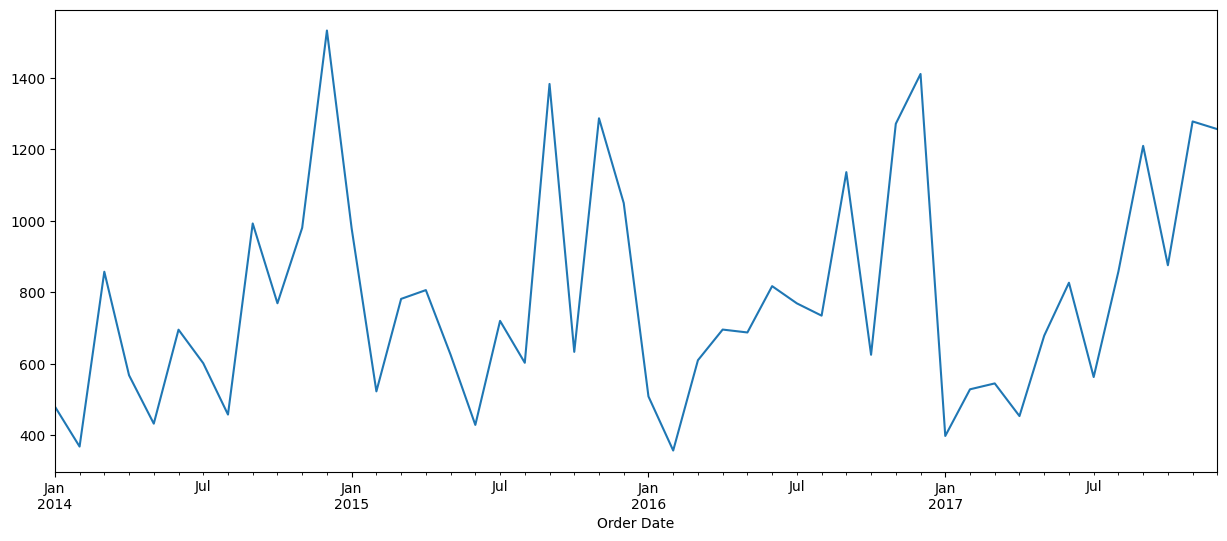

In [22]:
y.plot(figsize=(15, 6))
plt.show()

Some distinguishable patterns appear when we plot the data. The time-series has seasonality pattern, such as sales are always low at the beginning of the year and high at the end of the year. There is always a strong upward trend within any single year with a couple of low months in the mid of the year.

We can also visualize our data using a method called time-series decomposition that allows us to decompose our time series into three distinct components: trend, seasonality, and noise.

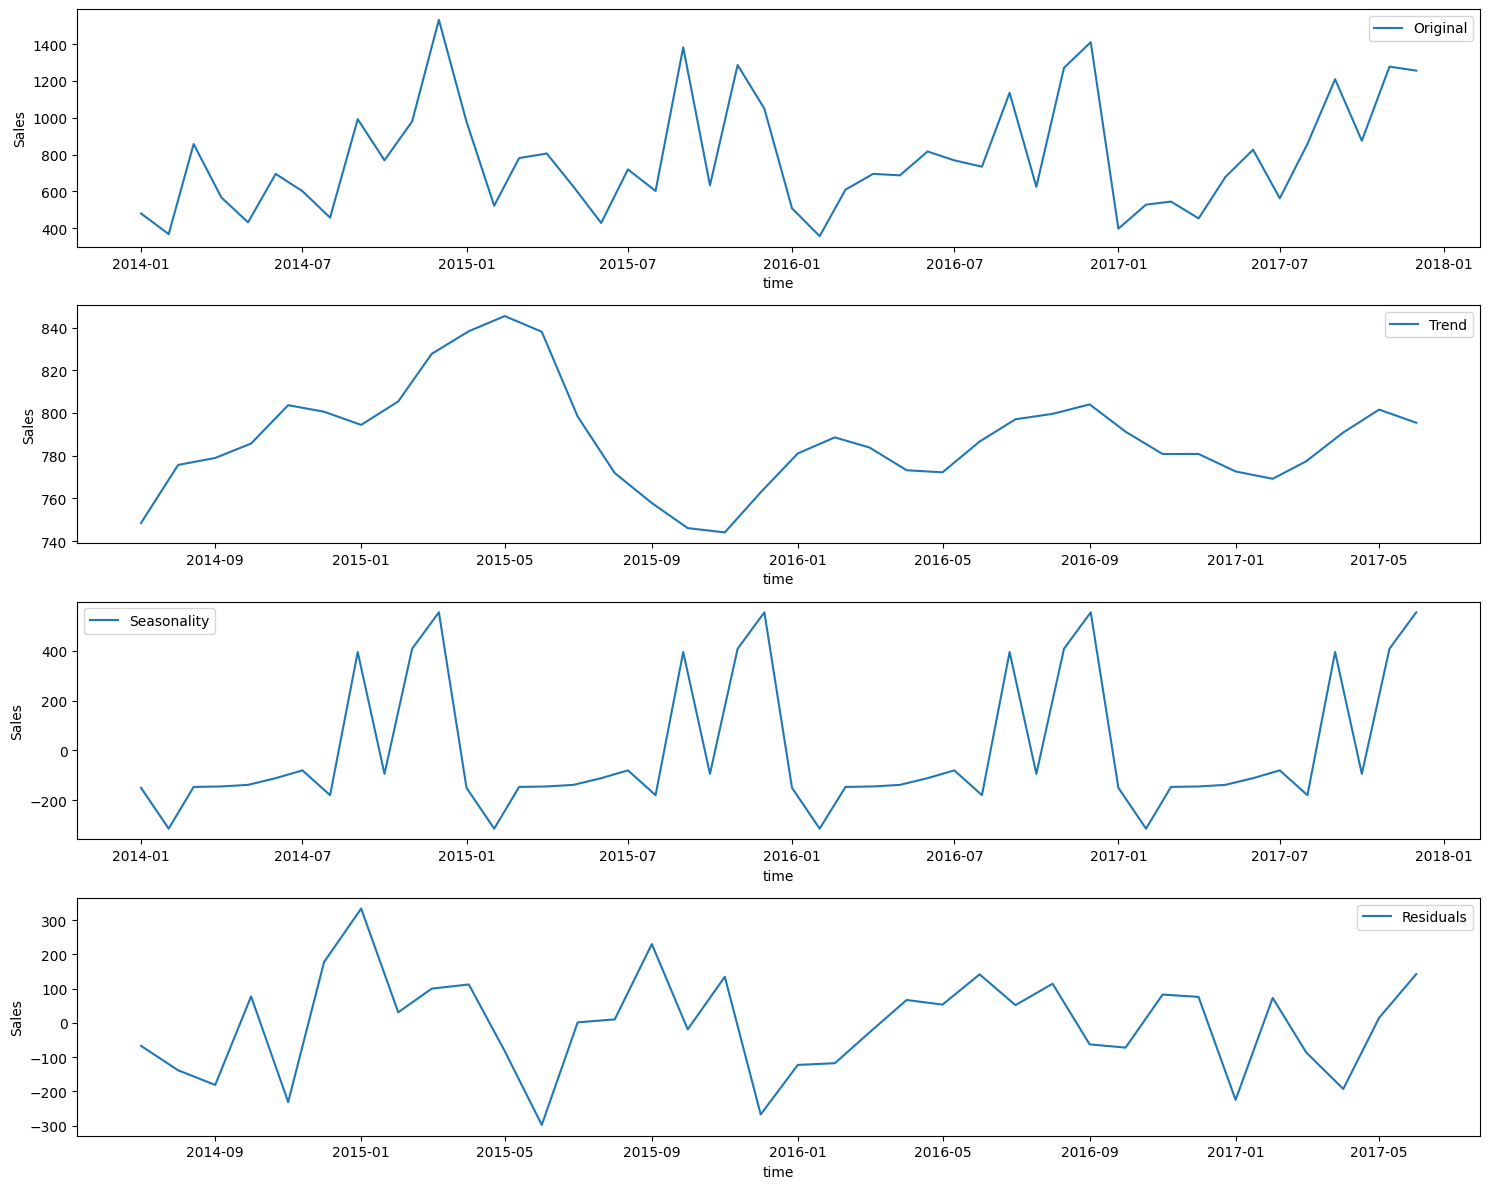

In [23]:
decomposition = seasonal_decompose(y, model='additive')
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(15, 12))

plt.subplot(411)
plt.plot(y, label='Original')
plt.legend(loc='best')
plt.ylabel('Sales')
plt.xlabel('time')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.ylabel('Sales')
plt.xlabel('time')

plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')
plt.ylabel('Sales')
plt.xlabel('time')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.ylabel('Sales')
plt.xlabel('time')

plt.tight_layout()
plt.show()


## Stationarity
- A Time Series is said to be stationary if its statistical properties such as mean, variance remain constant over time.
- Most of the Time Series models work on the assumption that the TS is stationary. Major reason for this is that there are many ways in which a series can be non-stationary, but only one way for stationarity.
- Intuitively, we can say that if a Time Series has a particular behaviour over time, there is a very high probability that it will follow the same in the future. 
- Also, the theories related to stationary series are more mature and easier to implement as compared to non-stationary series.

__We can check stationarity using the following:__

- __ACF and PACF plots__: If the time series is stationary, the ACF/PACF plots will show a __quick drop-off in correlation__ after a small amount of lag between points.
- __Plotting Rolling Statistics__: We can plot the moving average or moving variance and see if it varies with time. Moving average/variance is for any instant ‘t’, the average/variance of the last year, i.e. last 12 months.
- __Augmented Dickey-Fuller Test:__ This is one of the statistical tests for checking stationarity. Here the null hypothesis is that the TS is non-stationary. The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary.

### ACF and PACF plots

- Let's review the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots
- If the time series is stationary, the ACF/PACF plots will show a __quick drop-off in correlation__ after a small amount of lag between points.

# ACF and PACF plots

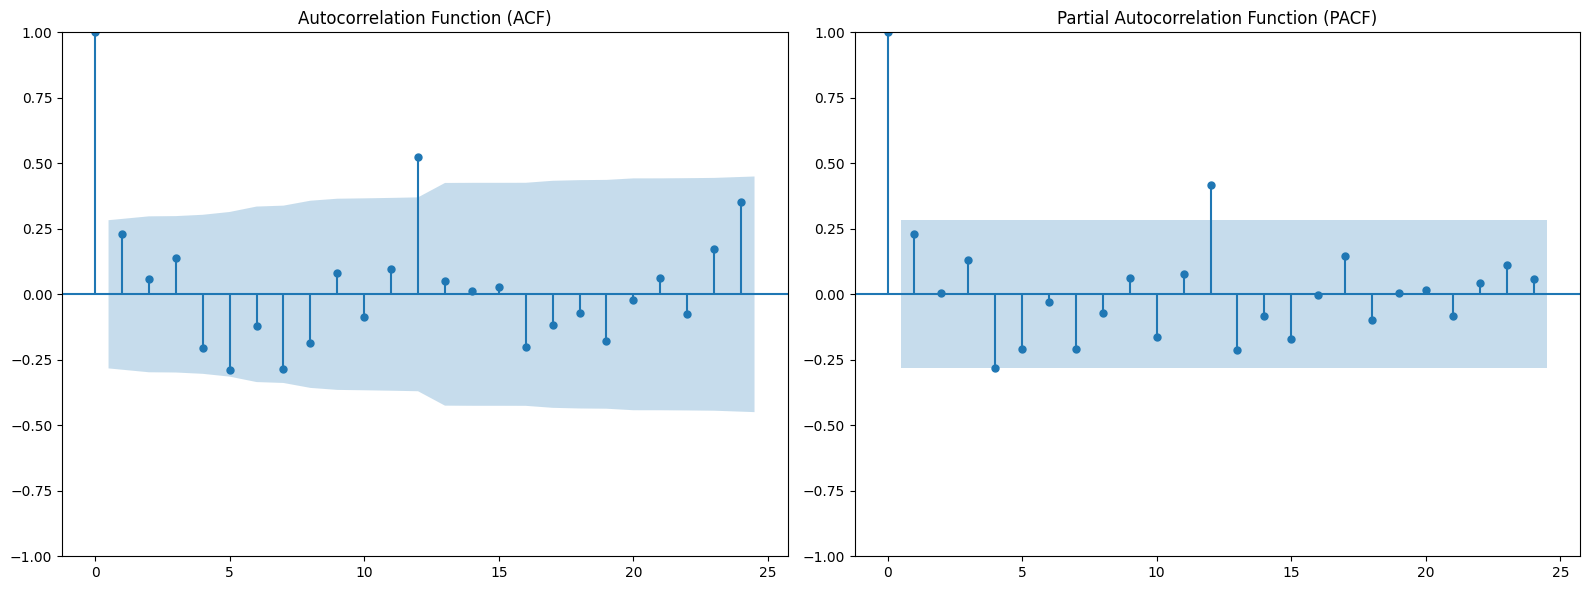

In [24]:
max_lags = int(len(y) / 2)
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

plot_acf(y, ax=ax[0], lags=max_lags)
ax[0].set_title('Autocorrelation Function (ACF)')

plot_pacf(y, ax=ax[1], lags=max_lags)
ax[1].set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

The plot above clearly shows that the sales of furniture is unstable, along with its obvious seasonality.

# Rolling Mean and Standard Deviation

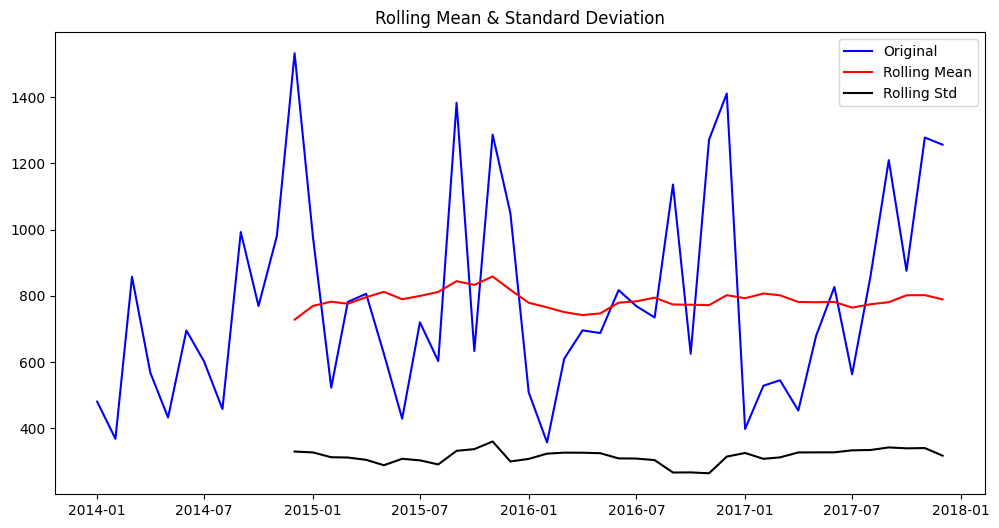

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

rolmean = y.rolling(window=12).mean()
rolstd = y.rolling(window=12).std()

plt.figure(figsize=(12, 6))
orig = plt.plot(y, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show()

### Plotting Rolling Statistics
- We observe that the rolling mean and Standard deviation are constant with respect to time.
- The time series is stationary.

# Augmented Dickey-Fuller Test


- The intuition behind the test is that if the series is integrated then the lagged level of the series y(t-1)  will provide no relevant information in predicting the change in y(t).
- Null hypothesis: The time series is not stationary
- Rejecting the null hypothesis (i.e. a very low p-value) will indicate staionarity

In [26]:
result = adfuller(y)

print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value}')

ADF Statistic: -5.191070187339271
p-value: 9.168756655665654e-06
Critical Values:
   1%: -3.6209175221605827
   5%: -2.9435394610388332
   10%: -2.6104002410518627


Since the ADF statistic is more negative than the critical values at the 1%, 5%, and 10% levels, and the p-value is significantly less than 0.05, I can conclude that:

This time series is stationary. This means that the series does not require differencing to achieve stationarity, and I can proceed with modeling without additional differencing.

# Autoregression (AR)
- The autoregression (AR) method models the next step in the sequence as a linear function of the observations at prior time steps.
- __Number of AR (Auto-Regressive) terms (p):__ p is the parameter associated with the auto-regressive aspect of the model, which incorporates past values i.e lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).

### Hyperparameter Tuning

In [27]:
lags = range(1, 16)
trends = ['n', 'c', 't', 'ct']
best_aic = np.inf
best_lag = None
best_trend = None
best_model = None

for lag in lags:
    for trend in trends:
        try:
            model = AutoReg(y, lags=lag, trend=trend, old_names=False)
            model_fit = model.fit()
            aic = model_fit.aic
            if aic < best_aic:
                best_aic = aic
                best_lag = lag
                best_trend = trend
                best_model = model_fit
        except:
            continue

print(f'Best lag: {best_lag}')
print(f'Best trend: {best_trend}')
print(f'Best AIC: {best_aic}')


Best lag: 15
Best trend: c
Best AIC: 465.8528970985054


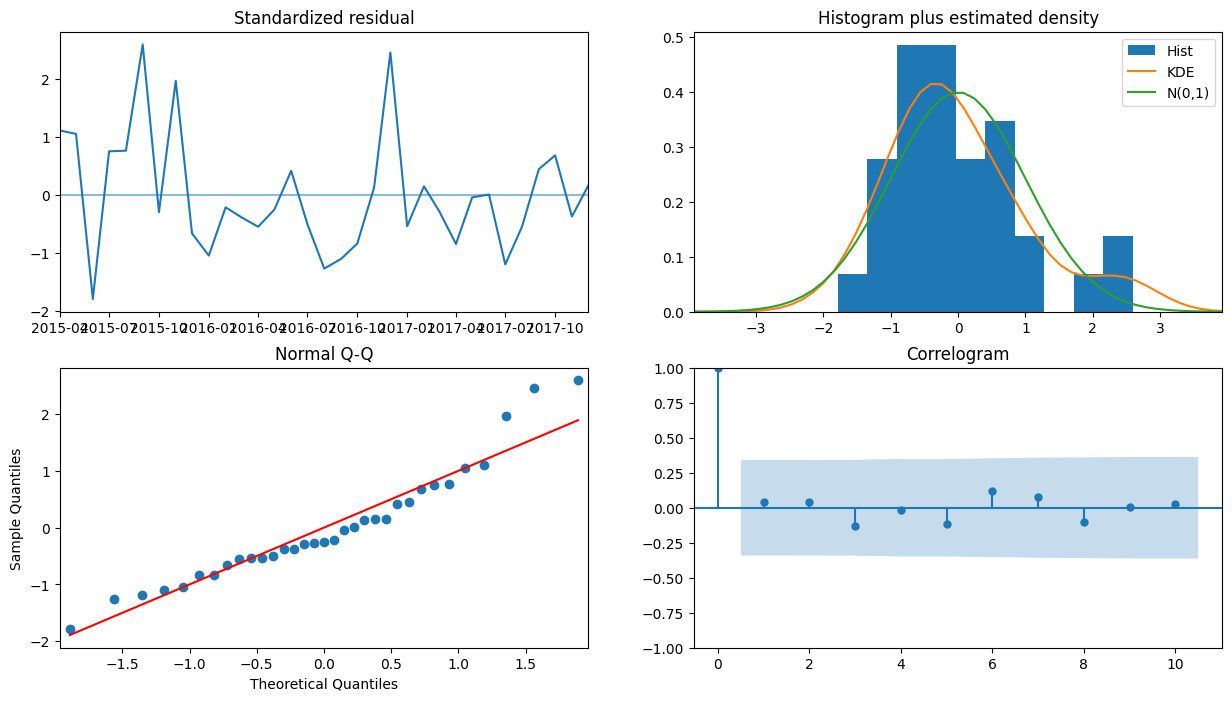

In [28]:
best_model.plot_diagnostics(figsize=(15, 8))
plt.show()

### Future Forecasting

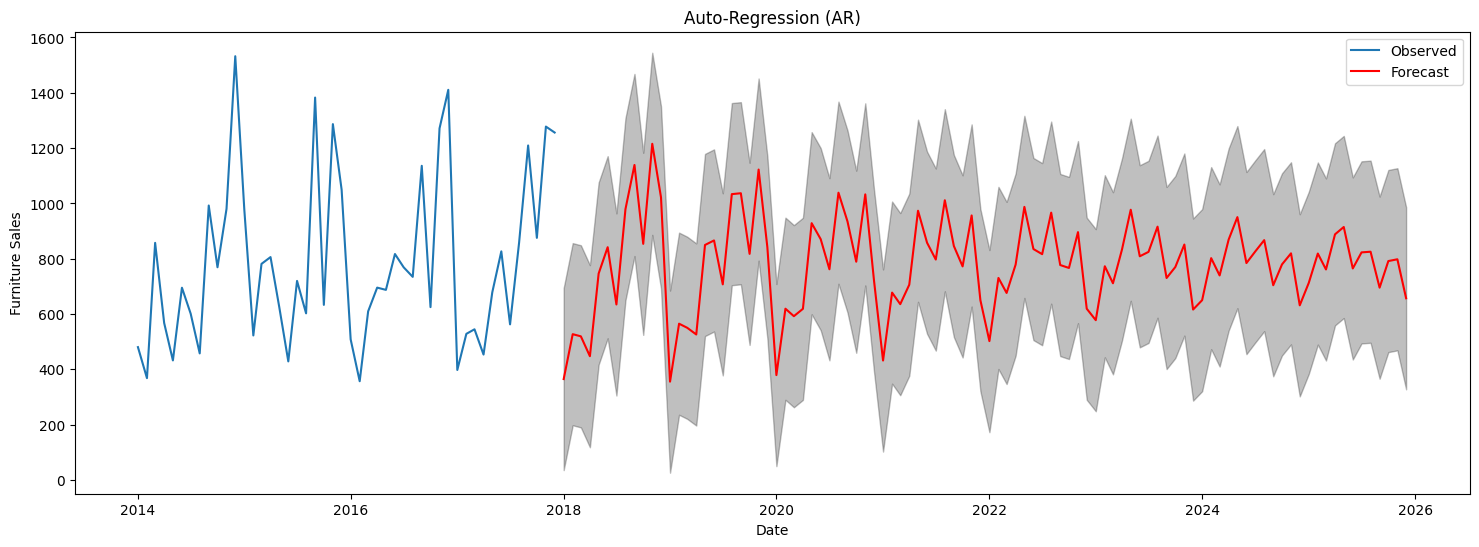

In [29]:
last_date = y.index[-1]
end_date = pd.to_datetime('2025-12-01')
n_periods = (end_date.year - last_date.year) * 12 + (end_date.month - last_date.month)
start = len(y)
end = start + n_periods - 1
predictions = best_model.predict(start=start, end=end, dynamic=False)

forecast_index = pd.date_range(start=y.index[-1] + pd.DateOffset(months=1), periods=n_periods, freq='MS')

forecast_se = np.sqrt(best_model.sigma2)
conf_int = np.array([predictions - 1.96 * forecast_se, predictions + 1.96 * forecast_se]).T

plt.figure(figsize=(18, 6))
plt.plot(y, label='Observed')
plt.plot(forecast_index, predictions, label='Forecast', color='red')
plt.fill_between(forecast_index, conf_int[:, 0], conf_int[:, 1], color='k', alpha=.25)
plt.xlabel('Date')
plt.ylabel('Furniture Sales')
plt.legend()
plt.title('Auto-Regression (AR)')
plt.show()

### Actual, Predicted and Residuals

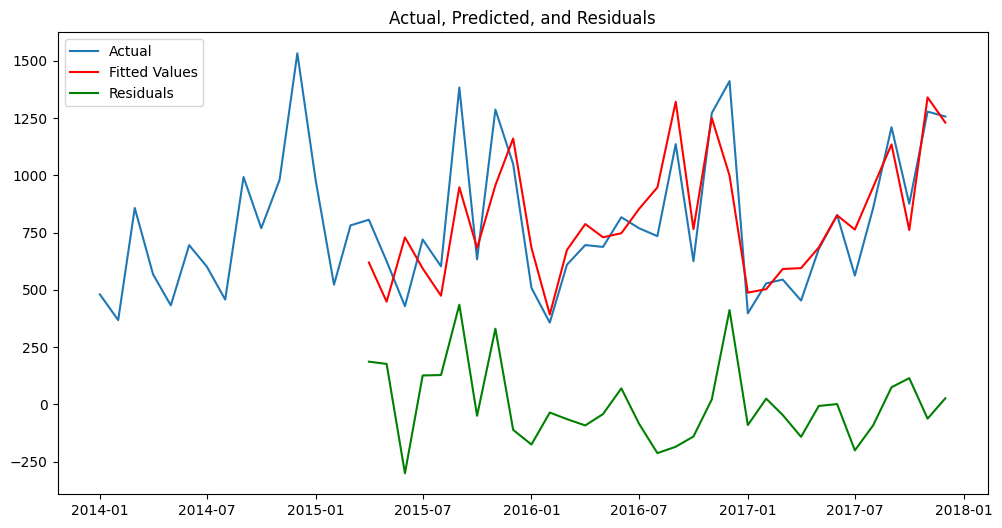

In [30]:
residuals = y - best_model.fittedvalues
plt.figure(figsize=(12, 6))
plt.plot(y, label='Actual')
plt.plot(best_model.fittedvalues, color='red', label='Fitted Values')
plt.plot(residuals, color='green', label='Residuals')
plt.title('Actual, Predicted, and Residuals')
plt.legend()
plt.show()

In [31]:
'RSS: %.4f'% np.nansum((best_model.fittedvalues-y)**2)

'RSS: 931994.2483'

### ACF and PACF plot of Residuals

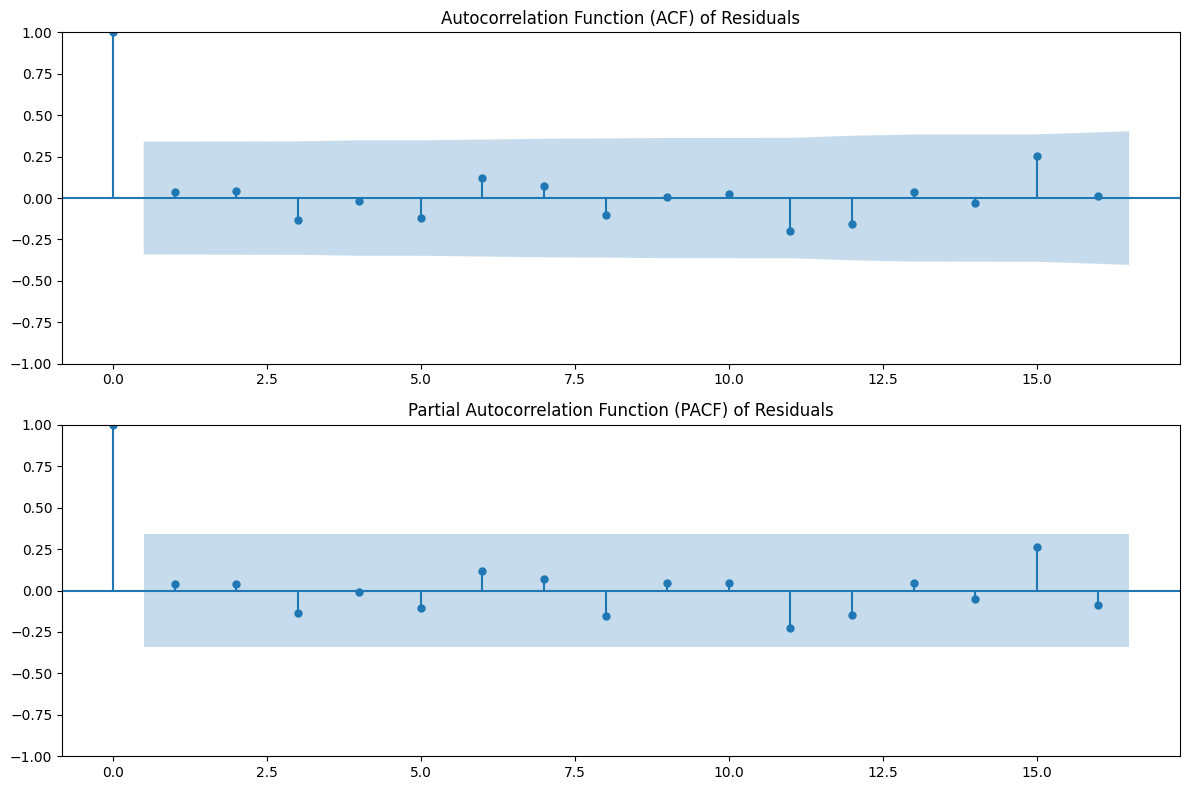

In [32]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

plot_acf(residuals.dropna(), ax=ax[0])
ax[0].set_title('Autocorrelation Function (ACF) of Residuals')

plot_pacf(residuals.dropna(), ax=ax[1])
ax[1].set_title('Partial Autocorrelation Function (PACF) of Residuals')

plt.tight_layout()
plt.show()

# Moving Average (MA)

- __Number of MA (Moving Average) terms (q):__ q is size of the moving average part window of the model i.e. lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value. 


### Hyperparameter Tuning

In [33]:
ma_orders = range(1, 16)
trends = ['n', 'c', 't', 'ct']

best_aic = np.inf
best_ma_order = None
best_trend = None
best_model = None

param_grid = product(ma_orders, trends)
for ma_order, trend in param_grid:
    try:
        model = ARIMA(y, order=(0, 0, ma_order), trend=trend)
        model_fit = model.fit()
        aic = model_fit.aic
        if aic < best_aic:
            best_aic = aic
            best_ma_order = ma_order
            best_trend = trend
            best_model = model_fit
    except Exception as e:
        print(f"Failed for parameters MA={ma_order}, Trend={trend}: {e}")
        continue

print(f'Best MA order: {best_ma_order}')
print(f'Best trend: {best_trend}')
print(f'Best AIC: {best_aic}')

c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization fail

Best MA order: 12
Best trend: c
Best AIC: 683.7634806618535


c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


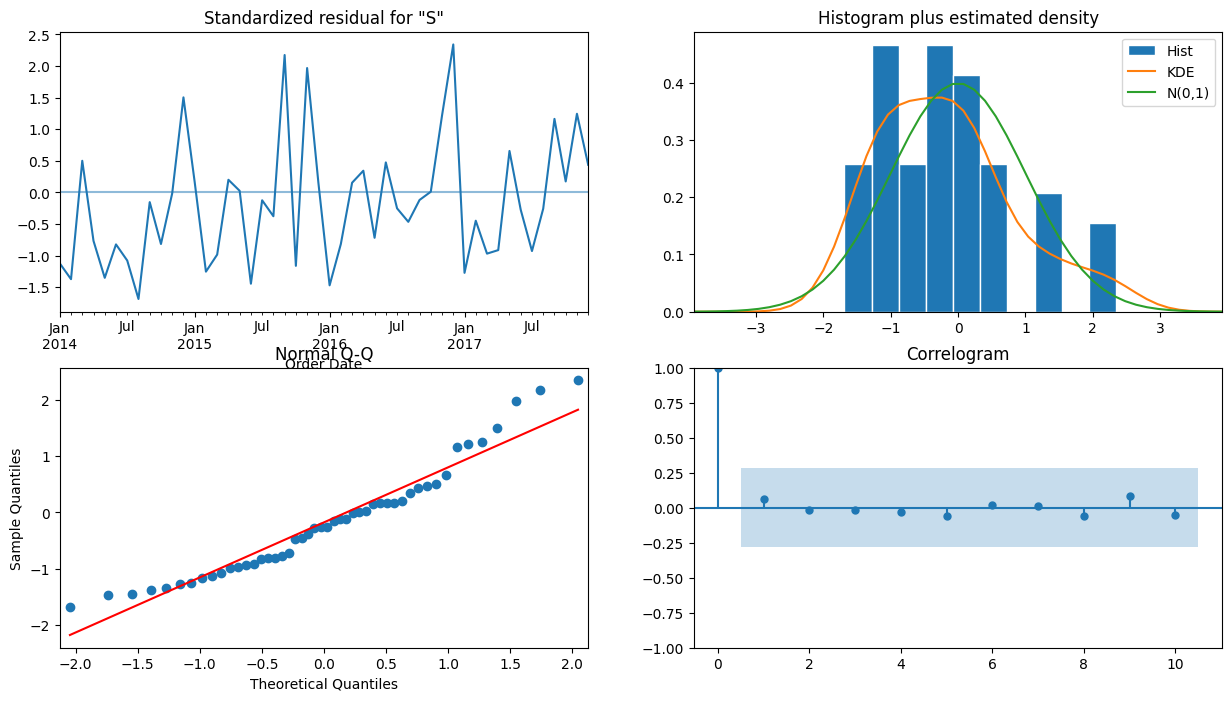

In [34]:
best_model.plot_diagnostics(figsize=(15, 8))
plt.show()

### Future Forecasting

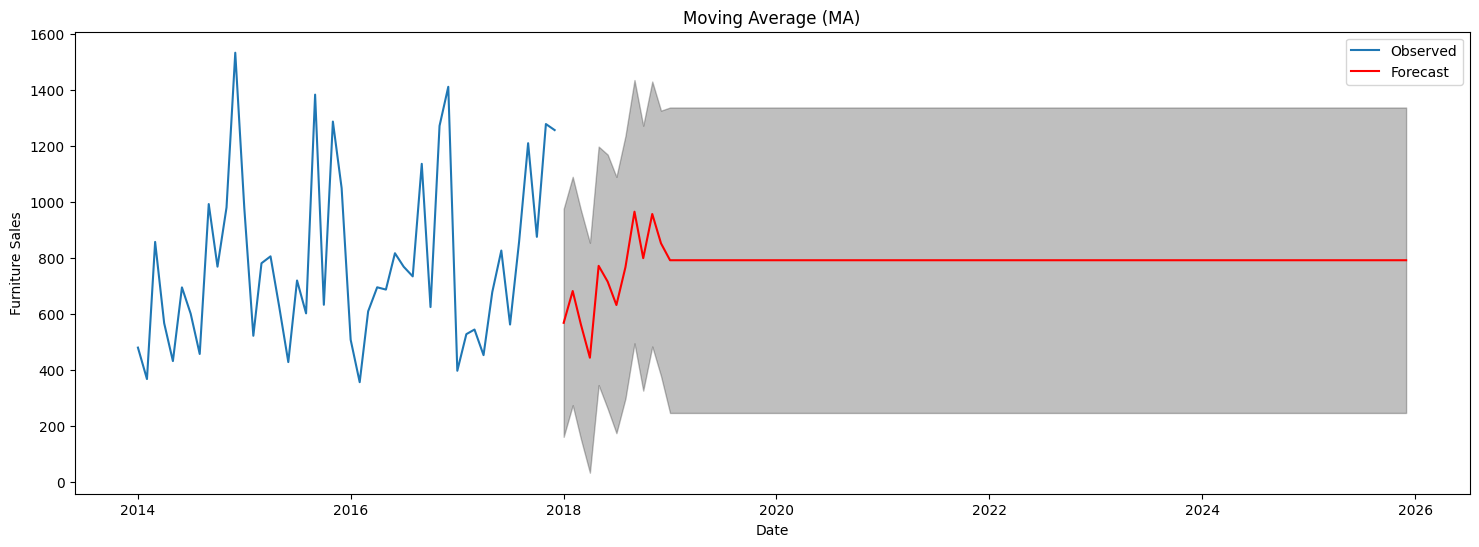

In [35]:
last_date = y.index[-1]
end_date = pd.to_datetime('2025-12-01')
n_periods = (end_date.year - last_date.year) * 12 + (end_date.month - last_date.month)

start = len(y)
predictions = best_model.get_forecast(steps=n_periods)
pred_mean = predictions.predicted_mean
conf_int = predictions.conf_int()

combined_series = pd.concat([y, pd.Series(pred_mean, index=pd.date_range(start=y.index[-1] + pd.DateOffset(months=1), periods=n_periods, freq='MS'))])

forecast_index = pd.date_range(start=y.index[-1] + pd.DateOffset(months=1), periods=n_periods, freq='MS')

plt.figure(figsize=(18, 6))
plt.plot(y, label='Observed')
plt.plot(forecast_index, pred_mean, label='Forecast', color='red')
plt.fill_between(forecast_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='k', alpha=.25)
plt.xlabel('Date')
plt.ylabel('Furniture Sales')
plt.legend()
plt.title('Moving Average (MA)')
plt.show()

### Actual, Predicted and Residuals

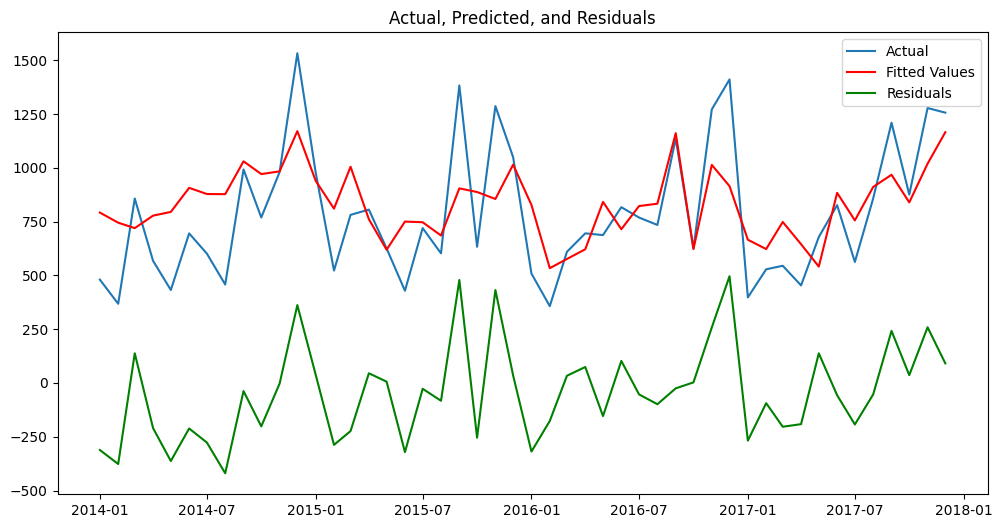

In [36]:
y_2014 = y[y.index >= '2014-01-01']
fitted_2014 = best_model.fittedvalues[best_model.fittedvalues.index >= '2014-01-01']
residuals_2014 = y_2014 - fitted_2014

plt.figure(figsize=(12, 6))
plt.plot(y_2014, label='Actual')
plt.plot(fitted_2014, color='red', label='Fitted Values')
plt.plot(residuals_2014, color='green', label='Residuals')
plt.title('Actual, Predicted, and Residuals')
plt.legend()
plt.show()

In [37]:
'RSS: %.4f'% np.nansum((best_model.fittedvalues-y)**2)

'RSS: 2489080.2474'

### ACF and PACF plot of Residuals

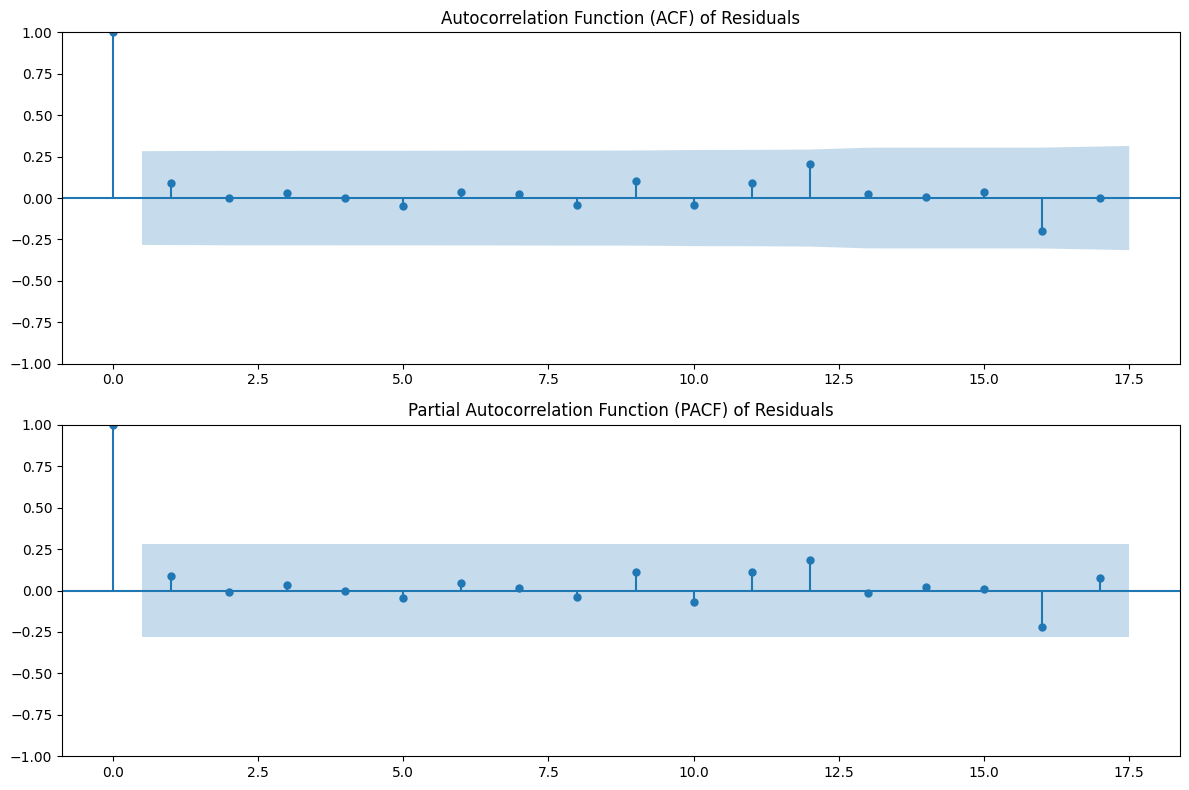

In [38]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

plot_acf(residuals_2014.dropna(), ax=ax[0])
ax[0].set_title('Autocorrelation Function (ACF) of Residuals')

plot_pacf(residuals_2014.dropna(), ax=ax[1])
ax[1].set_title('Partial Autocorrelation Function (PACF) of Residuals')

plt.tight_layout()
plt.show()

# ARIMA

### Hyperparameter Tuning

In [39]:
p = q = range(0, 3)
d = [0]
pdq = list(itertools.product(p, d, q))

best_aic = float("inf")
best_pdq = None
best_model = None

for param in pdq:
    try:
        mod = sm.tsa.ARIMA(y, order=param)
        results = mod.fit()
        if results.aic < best_aic:
            best_aic = results.aic
            best_pdq = param
            best_model = results
    except Exception as e:
        continue

print(f'Best ARIMA{best_pdq} - AIC:{best_aic}')


Best ARIMA(2, 0, 2) - AIC:677.6086068772679


c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


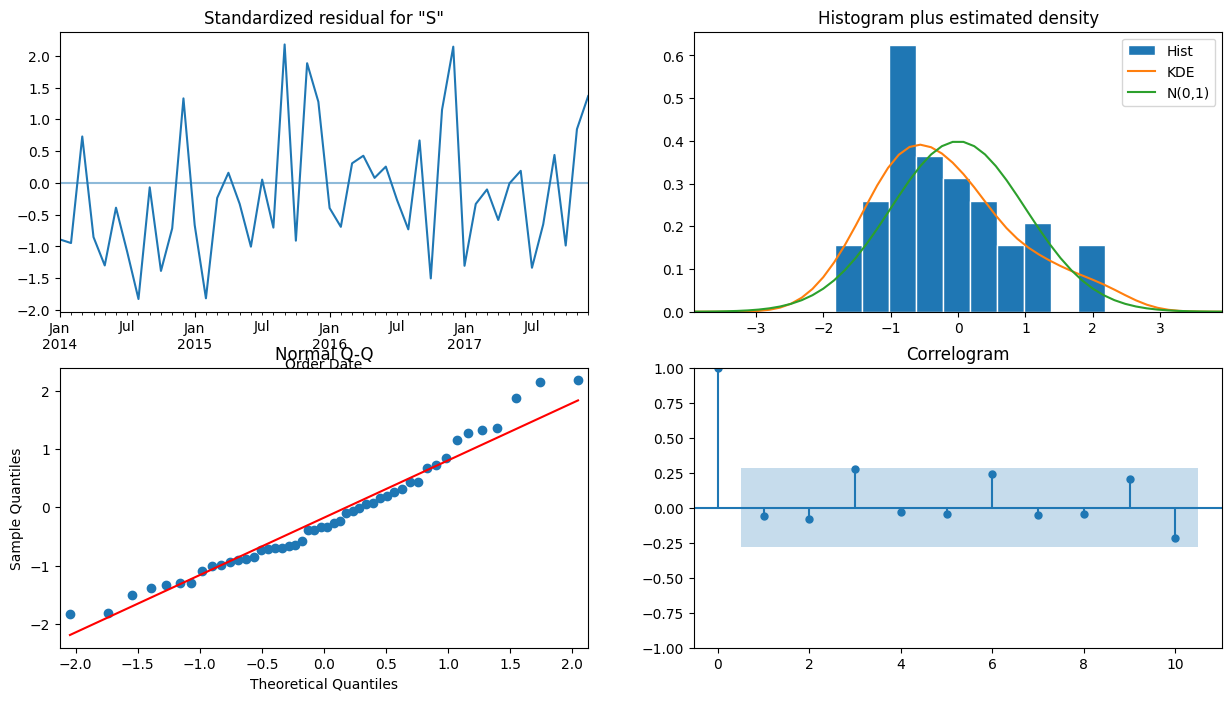

In [40]:
best_model.plot_diagnostics(figsize=(15, 8))
plt.show()

### Actual, Predicted and Residuals

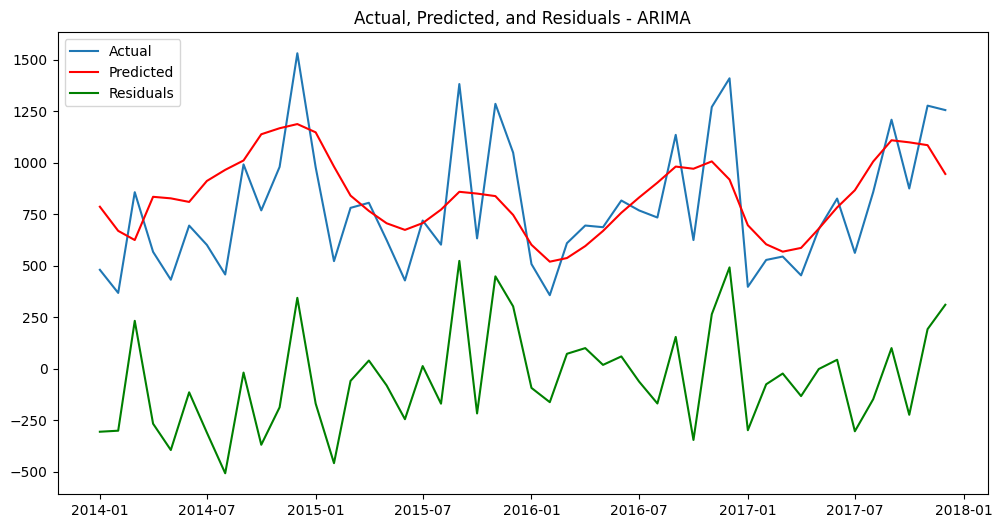

In [41]:
pred = best_model.predict(start=pd.to_datetime('2014-01-01'))
residuals = y['2014':] - pred

plt.figure(figsize=(12, 6))
plt.plot(y['2014':], label='Actual')
plt.plot(pred, color='red', label='Predicted')
plt.plot(residuals, color='green', label='Residuals')
plt.title('Actual, Predicted, and Residuals - ARIMA')
plt.legend()
plt.show()


### Future Forecasting

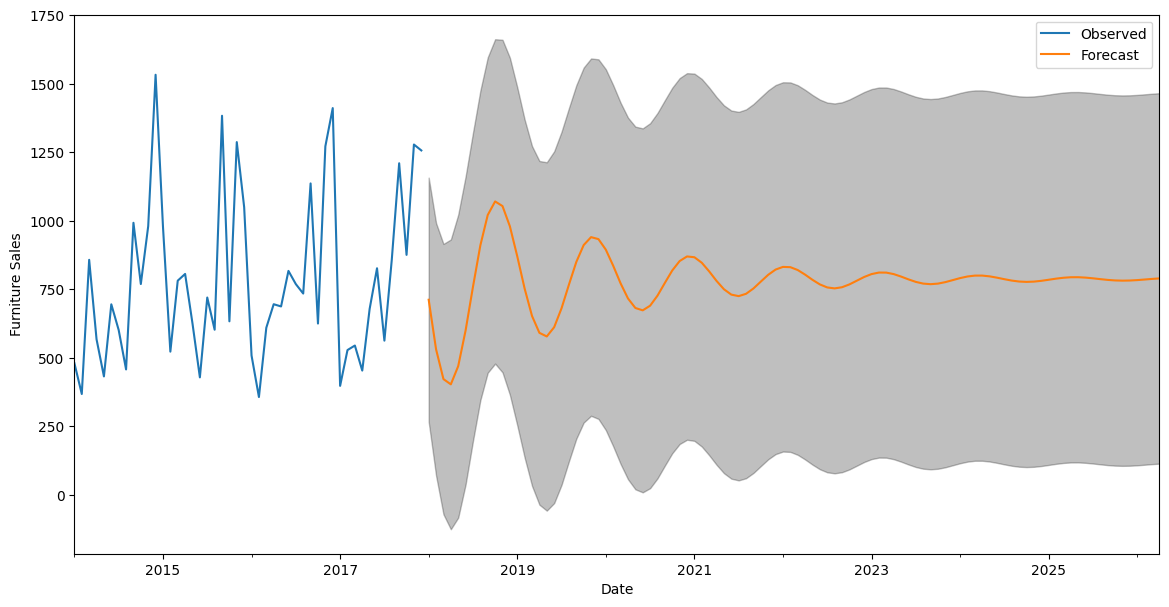

In [42]:
pred_uc = best_model.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()

ax = y.plot(label='Observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()


### ACF and PACF plot of Residuals

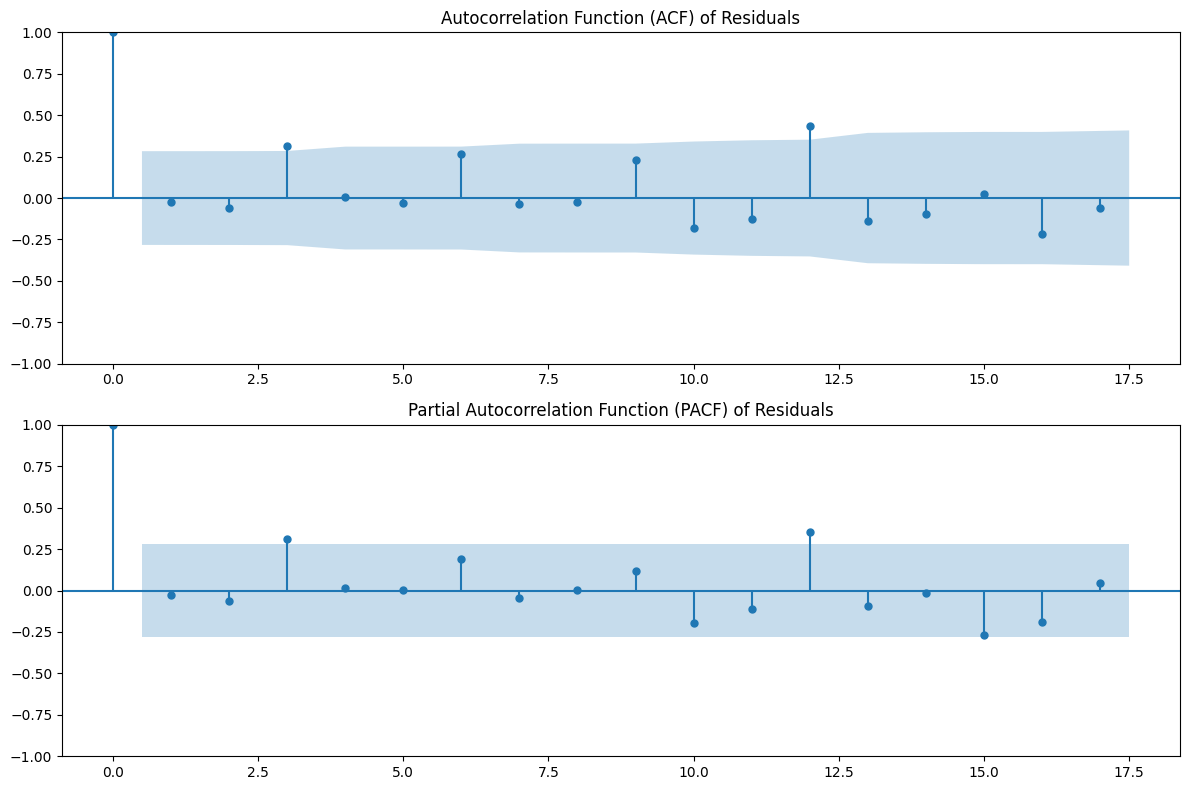

In [43]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(residuals.dropna(), ax=ax[0])
ax[0].set_title('Autocorrelation Function (ACF) of Residuals')
plot_pacf(residuals.dropna(), ax=ax[1])
ax[1].set_title('Partial Autocorrelation Function (PACF) of Residuals')
plt.tight_layout()
plt.show()

# SARIMA



In [44]:
p = q = range(0, 3)
d = [0]
P = [1]
Q = [0]
D = [1]
s = [12]

pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], s[0]) for x in list(itertools.product(P, D, Q))]

### Hyperparameter Tuning

In [45]:
best_aic = float("inf")
best_pdq = None
best_seasonal_pdq = None
best_model = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
                best_model = results
        except Exception as e:
            continue

print(f'Best SARIMA{best_pdq}x{best_seasonal_pdq} - AIC:{best_aic}')


Best SARIMA(2, 0, 2)x(1, 1, 0, 12) - AIC:288.561502080389


c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [46]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(2, 0, 2),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5820      0.158     10.013      0.000       1.272       1.892
ar.L2         -0.7554      0.118     -6.416      0.000      -0.986      -0.525
ma.L1         -1.9749      0.468     -4.224      0.000      -2.891      -1.059
ma.L2          1.0009      0.589      1.700      0.089      -0.153       2.155
ar.S.L12      -0.2632      0.134     -1.964      0.050      -0.526      -0.001
sigma2      1.464e+04   7.07e-05   2.07e+08      0.000    1.46e+04    1.46e+04


c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### Future Forecasting

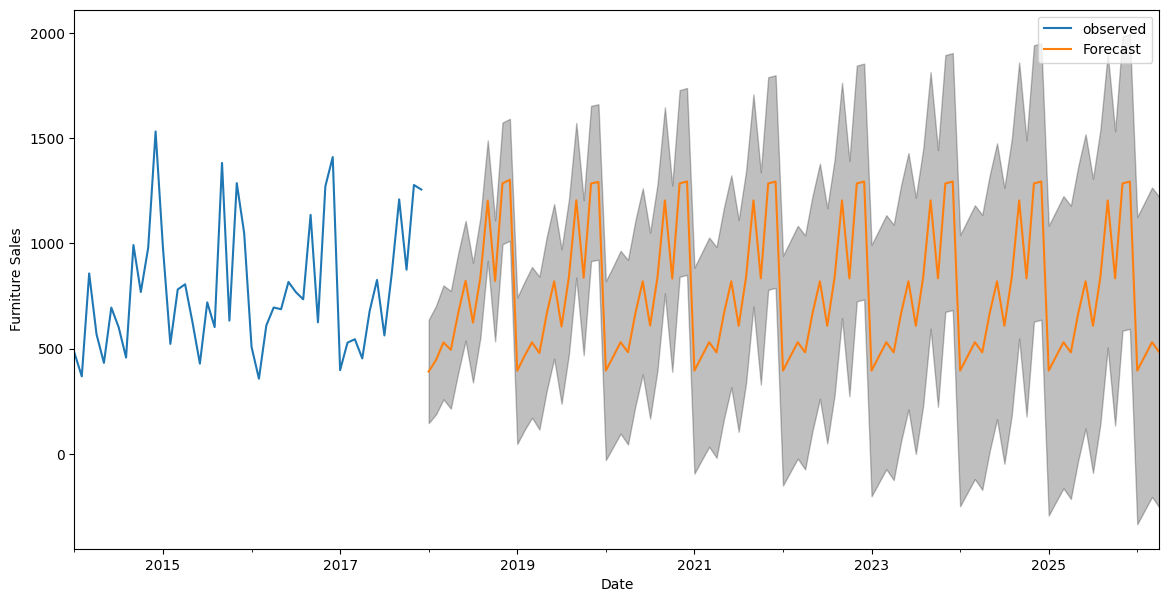

In [47]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()

ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')

plt.legend()
plt.show()

### validating forecast

To help us understand the accuracy of our forecasts, we compare predicted sales to real sales of the time series, and we set forecasts from starting to the end of the data.

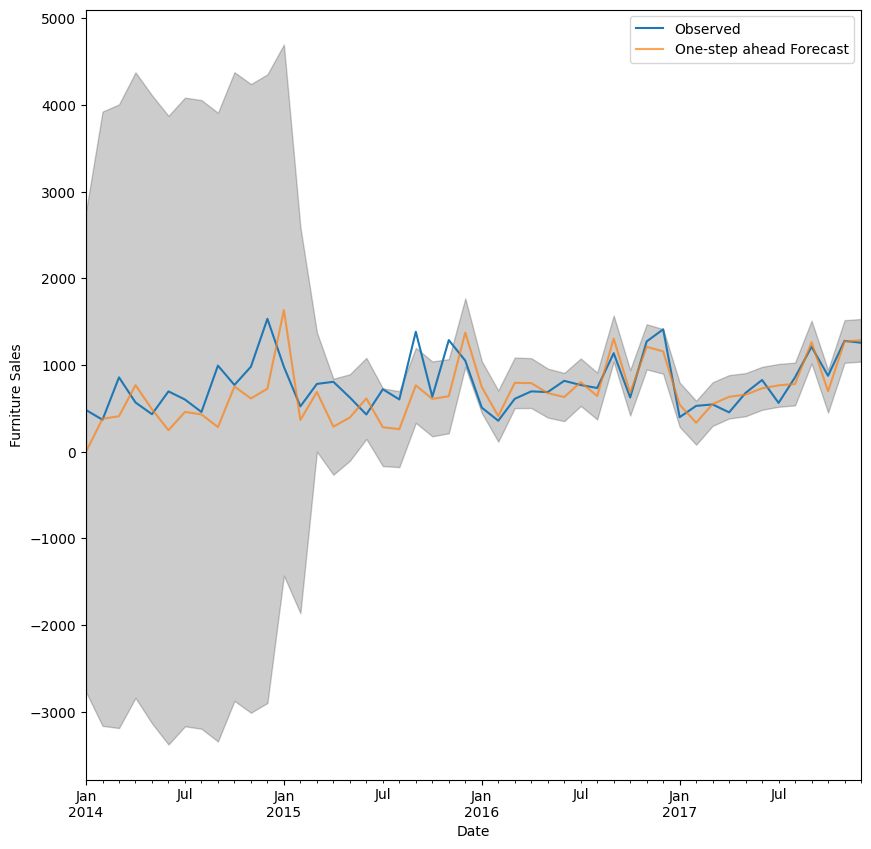

In [48]:
pred = results.get_prediction(start=pd.to_datetime('2014-01-01'), dynamic=False)
pred_ci = pred.conf_int()

ax = y['2014':].plot(label='Observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(10, 10))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

The line plot is showing the observed values compared to the rolling forecast predictions. Overall, our forecasts align with the true values very well, showing an upward trend starts from the beginning of the year.

### Actual, Predicted and Residuals

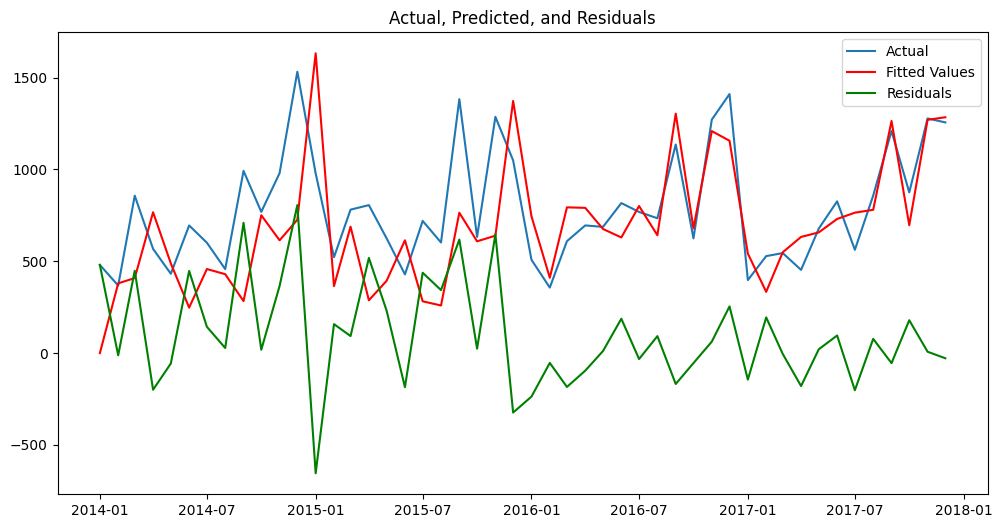

In [49]:
residuals = y['2014':] - pred.predicted_mean

plt.figure(figsize=(12, 6))
plt.plot(y['2014':], label='Actual')
plt.plot(pred.predicted_mean, color='red', label='Fitted Values')
plt.plot(residuals, color='green', label='Residuals')
plt.title('Actual, Predicted, and Residuals')
plt.legend()
plt.show()

In [50]:
'RSS: %.4f'% np.nansum((best_model.fittedvalues-y)**2)

'RSS: 4447169.4265'

### ACF and PACF plot of Residuals

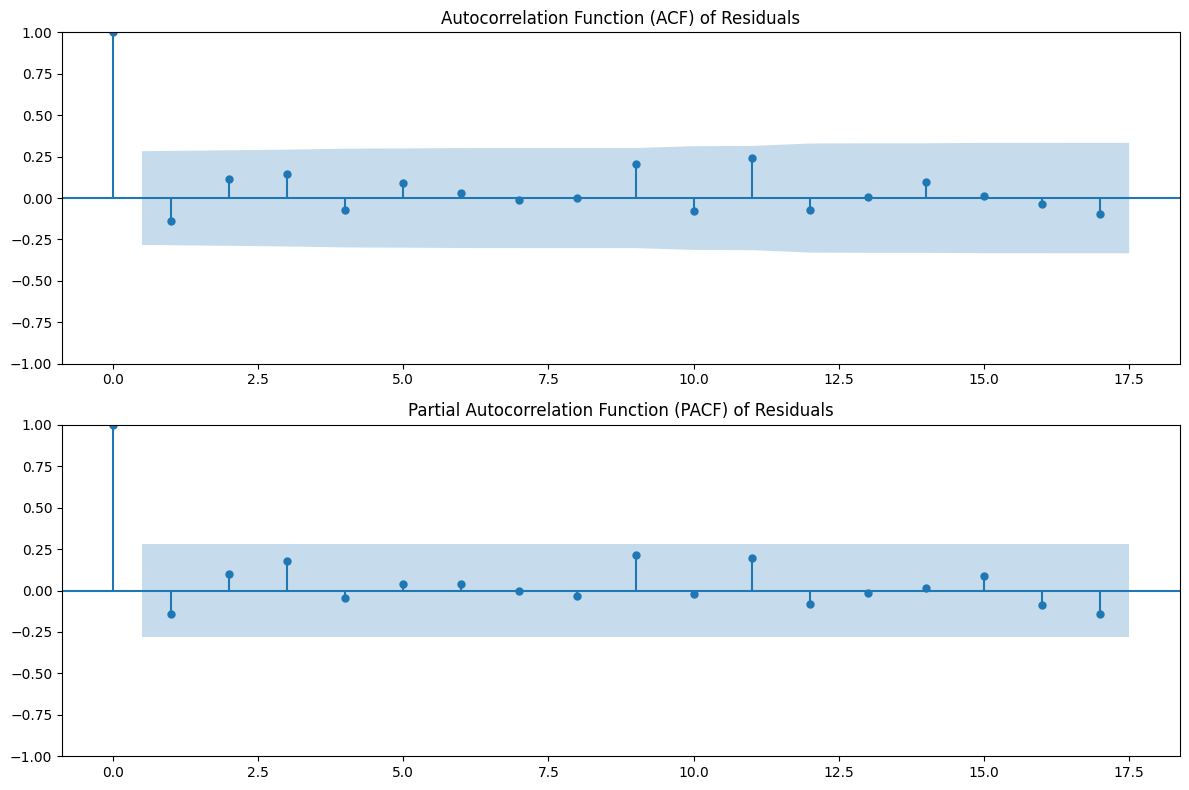

In [51]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

plot_acf(residuals.dropna(), ax=ax[0])
ax[0].set_title('Autocorrelation Function (ACF) of Residuals')

plot_pacf(residuals.dropna(), ax=ax[1])
ax[1].set_title('Partial Autocorrelation Function (PACF) of Residuals')

plt.tight_layout()
plt.show()

In [52]:
y_forecasted = pred.predicted_mean
y_truth = y['2014-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 92649.36


In [53]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 304.38


In statistics, the mean squared error (MSE) of an estimator measures the average of the squares of the errors — that is, the average squared difference between the estimated values and what is estimated. The MSE is a measure of the quality of an estimator—it is always non-negative, and the smaller the MSE, the closer we are to finding the line of best fit.

Root Mean Square Error (RMSE) tells us that our model was able to forecast the average daily furniture sales in the test set within 304.58 of the real sales. Our furniture daily sales range from around 400 to over 1200. In my opinion, this is a pretty good model so far.

Our model clearly captured furniture sales seasonality. As we forecast further out into the future, it is natural for us to become less confident in our values. This is reflected by the confidence intervals generated by our model, which grow larger as we move further out into the future.

The above time series analysis for furniture makes me curious about other categories, and how do they compare with each other onver time. Therefore, we are going to compare time series of furniture and office supplier.

# Auto ARIMA

In [54]:
import pmdarima as pm
from pmdarima import auto_arima

### Choosing the best parameter

In [55]:
auto_model = auto_arima(y,
                        seasonal=True,
                        m=12,
                        trace=True,
                        error_action='ignore',  
                        suppress_warnings=True,
                        stepwise=True)

print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=494.537, Time=1.30 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=497.083, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=494.685, Time=0.58 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.60 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=495.371, Time=0.03 sec
 ARIMA(2,0,2)(0,1,1)[12] intercept   : AIC=inf, Time=1.11 sec
 ARIMA(2,0,2)(1,1,0)[12] intercept   : AIC=496.070, Time=1.49 sec
 ARIMA(2,0,2)(2,1,1)[12] intercept   : AIC=501.846, Time=2.45 sec
 ARIMA(2,0,2)(1,1,2)[12] intercept   : AIC=500.275, Time=2.82 sec
 ARIMA(2,0,2)(0,1,0)[12] intercept   : AIC=inf, Time=0.66 sec
 ARIMA(2,0,2)(0,1,2)[12] intercept   : AIC=495.008, Time=2.19 sec
 ARIMA(2,0,2)(2,1,0)[12] intercept   : AIC=inf, Time=2.36 sec
 ARIMA(2,0,2)(2,1,2)[12] intercept   : AIC=503.541, Time=2.74 sec
 ARIMA(1,0,2)(1,1,1)[12] intercept   : AIC=498.528, Time=1.11 sec
 ARIMA(2,0,1)(1,1,1)[12] intercept   : AIC=inf, T

In [56]:
order = auto_model.order
seasonal_order = auto_model.seasonal_order

### model fitting

In [57]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=order,
                                seasonal_order=seasonal_order,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])
print(f'AIC value : {results.aic}')

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3791      0.661      2.086      0.037       0.083       2.675
ar.L2         -0.6334      0.366     -1.729      0.084      -1.352       0.085
ma.L1         -1.6185      0.929     -1.741      0.082      -3.440       0.203
ma.L2          0.6491      0.998      0.650      0.515      -1.307       2.605
ar.S.L12      -0.2228      0.275     -0.809      0.418      -0.763       0.317
ma.S.L12       0.0103      0.519      0.020      0.984      -1.006       1.027
sigma2      1.958e+04   1.01e+04      1.936      0.053    -245.689    3.94e+04
AIC value : 280.1366453168946


c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### validating forecasts

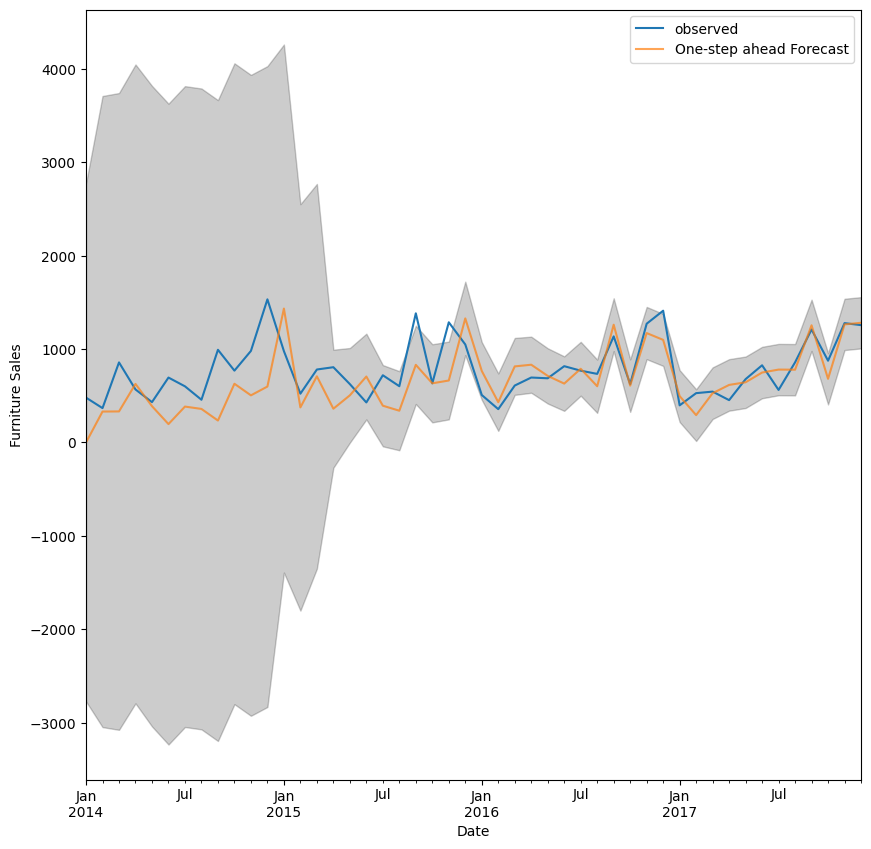

In [58]:
pred = results.get_prediction(start=pd.to_datetime('2014-01-01'), dynamic=False)
pred_ci = pred.conf_int()

ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(10,10))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()

plt.show()

### Future Forecasting

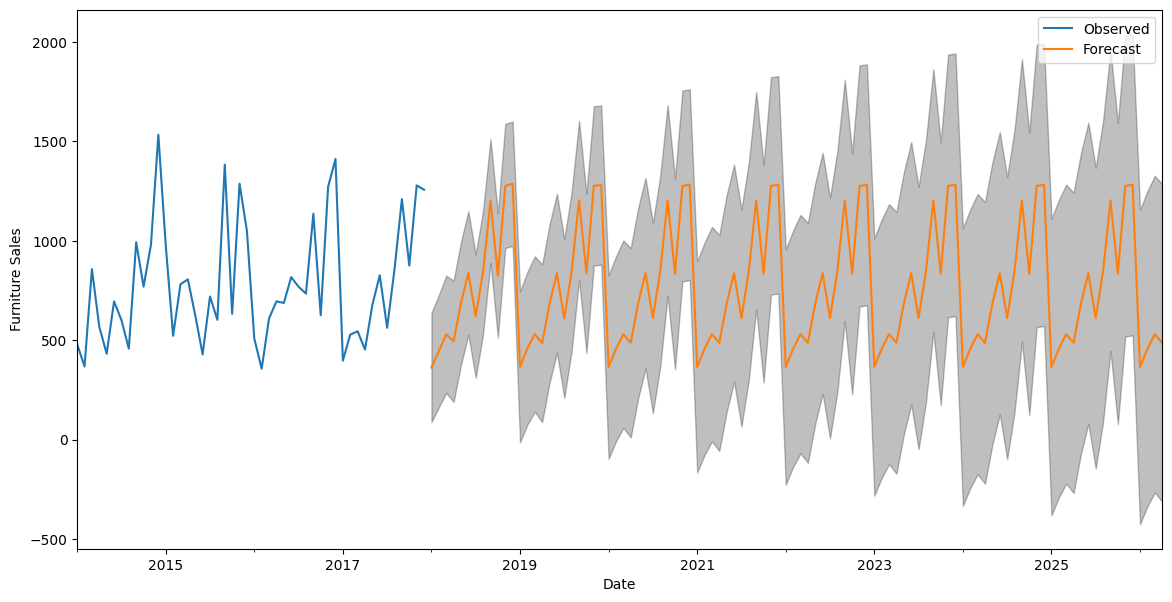

In [59]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()

ax = y.plot(label='Observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

### Actual, Predicted and Residuals

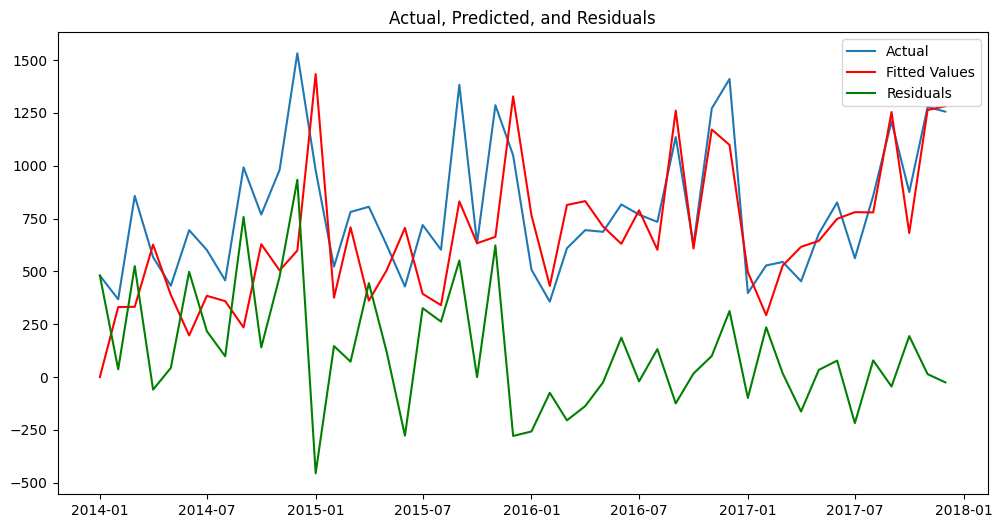

In [60]:
residuals = y['2014':] - pred.predicted_mean

plt.figure(figsize=(12, 6))
plt.plot(y['2014':], label='Actual')
plt.plot(pred.predicted_mean, color='red', label='Fitted Values')
plt.plot(residuals, color='green', label='Residuals')
plt.title('Actual, Predicted, and Residuals')
plt.legend()
plt.show()

### ACF and PACF plot of Residuals

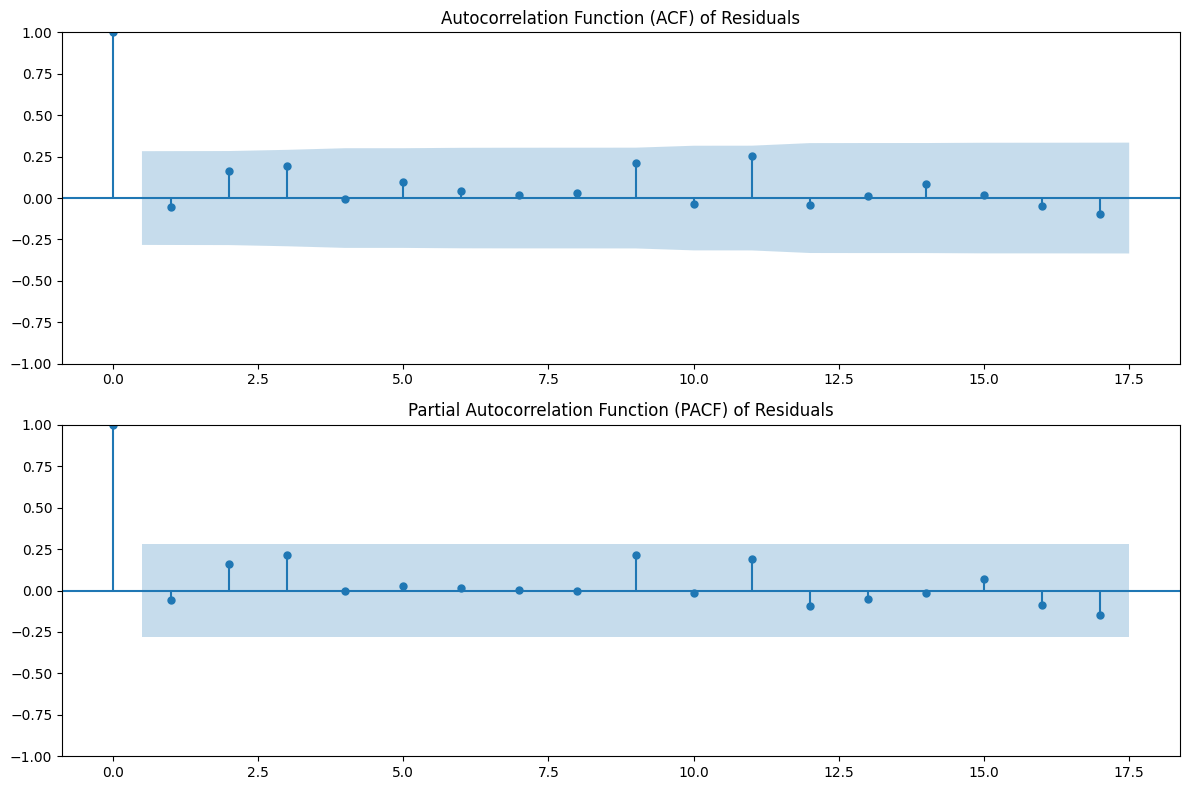

In [61]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(residuals.dropna(), ax=ax[0])
ax[0].set_title('Autocorrelation Function (ACF) of Residuals')
plot_pacf(residuals.dropna(), ax=ax[1])
ax[1].set_title('Partial Autocorrelation Function (PACF) of Residuals')
plt.tight_layout()
plt.show()


In [62]:
y_forecasted = pred.predicted_mean
y_truth = y['2014-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
rmse = np.sqrt(mse)
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))

The Mean Squared Error of our forecasts is 93332.46
The Root Mean Squared Error of our forecasts is 305.5
